In [4]:
import pandas as pd
import numpy as np

import datetime

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
df_train  = pd.read_csv('/content/gdrive/MyDrive/data/train.csv')  
df_test   = pd.read_csv('/content/gdrive/MyDrive/data/test.csv')  
df_target = pd.read_csv('/content/gdrive/MyDrive/data/target.csv')  

# Data Analysis

## **1**. Remove the outliers

In [7]:
df_train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.166915e+06,1.166915e+06,1.166915e+06,1.166915e+06,1.166915e+06,1.166915e+06,1.166915e+06
mean,1.534915e+00,1.665292e+00,-7.397346e+01,4.075089e+01,-7.397340e+01,4.075182e+01,9.584392e+02
std,4.987797e-01,1.314746e+00,6.231408e-02,3.173031e-02,6.157028e-02,3.645646e-02,5.334345e+03
min,1.000000e+00,0.000000e+00,-1.219332e+02,3.435970e+01,-1.219332e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399186e+01,4.073731e+01,-7.399133e+01,4.073591e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398175e+01,4.075407e+01,-7.397977e+01,4.075453e+01,6.630000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076834e+01,-7.396303e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,4.437194e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [8]:
mean = df_train['trip_duration'].mean()
sd = df_train['trip_duration'].std()

In [9]:
df_train.shape

(1166915, 11)

In [10]:
df_train = df_train[(df_train['trip_duration'] <= mean+(2*sd))] 

In [11]:
df_train.shape

(1165250, 11)

Άρα αφαιρέθηκαν 1166915 - 1165250 = **1665** outliers χρησιμοποιώντας standard deviation.



## **2**. Define NY borders

In [12]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

# Drop all the points outside the city of NY for the train data set
df_train = df_train[(df_train['pickup_longitude'] >= city_long_border[0]) & (df_train['pickup_longitude'] <= city_long_border[1])]
df_train = df_train[(df_train['dropoff_longitude'] >= city_long_border[0]) & (df_train['dropoff_longitude'] <= city_long_border[1])]

df_train = df_train[(df_train['pickup_latitude'] >= city_lat_border[0]) & (df_train['pickup_latitude'] <= city_lat_border[1])]
df_train = df_train[(df_train['dropoff_latitude'] >= city_lat_border[0]) & (df_train['dropoff_latitude'] <= city_lat_border[1])]

In [13]:
df_train.shape

(1149734, 11)

Άρα αφαιρέθηκαν 1165250 - 1149734 = **15516** σημεία στο train set.

## **3.** Add new columns

In [14]:
# Convert all columns with pd.to_datetime()

df_train['pickup_datetime'] = pd.to_datetime(df_train['pickup_datetime'])
df_train['dropoff_datetime'] = pd.to_datetime(df_train['dropoff_datetime'])

df_test['pickup_datetime'] = pd.to_datetime(df_test['pickup_datetime'])

### Add day_period column

In [15]:
# Define the day periods
morning_1 = datetime.time(6,00,00)    # 6:00 am
morning_2 = datetime.time(11,59,59)   # 11.59 am

afternoon_1 = datetime.time(12,00,00)   # 12:00 pm
afternoon_2 = datetime.time(15,59,59)   # 3:59 pm

evening_1 = datetime.time(16,00,00)   # 4:00 pm
evening_2 = datetime.time(21,59,59)   # 9:59pm

late_night_1 = datetime.time(22,00,00)  # 10:00 pm
late_night_2 = datetime.time(5,59,59)   # 5:59 am

In [16]:
def add_day_period(df, column_name, new_col_name):

  # Extract the timestamps
  pickup_timestamps = df[column_name].dt.time

  conditions = [
                
    (pickup_timestamps >= morning_1) & (pickup_timestamps <= morning_2),
    (pickup_timestamps >= afternoon_1) & (pickup_timestamps <= afternoon_2),
    (pickup_timestamps >= evening_1) & (pickup_timestamps <= evening_2),
    ((pickup_timestamps >= late_night_1) & (pickup_timestamps <= datetime.time(23,59,59))) | ((pickup_timestamps >= datetime.time(00,00,00)) & (pickup_timestamps <= late_night_2))]

  # create a list of the values we want to assign for each condition
  values = ['Morning', 'Afternoon', 'Evening', 'Late Night']
  
  # create a new column and use np.select to assign values to it using our lists as arguments
  df[new_col_name] = np.select(conditions, values)

  return df

In [17]:
# Add the new columns to df_train
df_train = add_day_period(df_train, 'pickup_datetime', 'pickup_day_period')
df_train = add_day_period(df_train, 'dropoff_datetime', 'dropoff_day_period')

# Add the new column to df_test
df_test = add_day_period(df_test, 'pickup_datetime', 'pickup_day_period')

### Add day_name column

In [18]:
import calendar

In [19]:
def add_day_name(df, column, new_col_name):
  
  week_days = df[column].dt.date
  day_names = [calendar.day_name[name.weekday()] for name in week_days]
  df[new_col_name] = day_names

  return df

In [20]:
# Add the new columns to df_train
df_train = add_day_name(df_train, 'pickup_datetime', 'pickup_day_name')
df_train = add_day_name(df_train, 'dropoff_datetime', 'dropoff_day_name')

# Add the new column to df_test
df_test = add_day_name(df_test, 'pickup_datetime', 'pickup_day_name')

### Add month column

In [21]:
def add_month(df, column_name, new_col_name):

  months = df[column_name].dt.month_name()
  df[new_col_name] = months.tolist()
  return df

In [22]:
# Add the new columns to df_train
df_train = add_month(df_train, 'pickup_datetime', 'pickup_month')
df_train = add_month(df_train, 'dropoff_datetime', 'dropoff_month')

# Add the new column to df_test
df_test = add_month(df_test, 'pickup_datetime', 'pickup_month')

### Add hour column

In [23]:
def add_hour(df, column_name, new_col_name):

  hours = df[column_name].dt.hour
  df[new_col_name] = hours.tolist()
  return df

In [24]:
# Add the new columns to df_train
df_train = add_hour(df_train, 'pickup_datetime', 'pickup_hour')
df_train = add_hour(df_train, 'dropoff_datetime', 'dropoff_hour')

# Add the new column to df_test
df_test = add_hour(df_test, 'pickup_datetime', 'pickup_hour')

### Add year column

In [25]:
def add_year(df, column_name, new_col_name):
  
  years = df[column_name].dt.year
  df[new_col_name] = years.tolist()
  return df

In [26]:
# Add the new columns to df_train
df_train = add_year(df_train, 'pickup_datetime', 'pickup_year')
df_train = add_year(df_train, 'dropoff_datetime', 'dropoff_year')

# Add the new column to df_test
df_test = add_year(df_test, 'pickup_datetime', 'pickup_year')

### Add season column

In [27]:
def add_season(df, column, new_col_name):
  
  months = df[column].dt.month

  #create a list of our conditions
  conditions = [
      ((months == 12) | (months < 3)),  # Winter
      ((months >= 3) & (months < 6)),   # Spring
      ((months >= 6) & (months < 9)),   # Summer
      ((months >= 9) & (months < 12)),  # Fall
      ]

  values = ['Winter', 'Spring', 'Summer', 'Fall']

  df[new_col_name] = np.select(conditions, values)

  return df

In [28]:
# Add the new columns to df_train
df_train = add_season(df_train, 'pickup_datetime', 'pickup_season')
df_train = add_season(df_train, 'dropoff_datetime', 'dropoff_season')

# Add the new column to df_test
df_test = add_season(df_test, 'pickup_datetime', 'pickup_season')

In [29]:
# Check that all the columns have been added in both datasets
df_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_day_name,dropoff_day_name,pickup_month,dropoff_month,pickup_hour,dropoff_hour,pickup_year,dropoff_year,pickup_season,dropoff_season
0,id2575240,2,2016-04-09 08:41:59,2016-04-09 08:48:11,1,-73.976501,40.788368,-73.957657,40.782452,N,...,Saturday,Saturday,April,April,8,8,2016,2016,Spring,Spring
1,id3828278,2,2016-04-07 11:12:45,2016-04-07 11:24:24,1,-73.992310,40.769211,-73.990662,40.758137,N,...,Thursday,Thursday,April,April,11,11,2016,2016,Spring,Spring
2,id1483137,2,2016-04-15 19:53:35,2016-04-15 20:04:49,1,-73.994713,40.746391,-73.969742,40.758484,N,...,Friday,Friday,April,April,19,20,2016,2016,Spring,Spring
3,id0416660,2,2016-04-21 00:47:17,2016-04-21 00:53:41,1,-73.988358,40.718460,-73.951538,40.713840,N,...,Thursday,Thursday,April,April,0,0,2016,2016,Spring,Spring
4,id2363476,1,2016-01-26 18:34:23,2016-01-26 19:09:14,1,-73.992332,40.743576,-73.979309,40.678200,N,...,Tuesday,Tuesday,January,January,18,19,2016,2016,Winter,Winter


In [30]:
df_test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_day_period,pickup_day_name,pickup_month,pickup_hour,pickup_year,pickup_season
0,id3206885,2,2016-03-16 05:59:42,5,-73.977753,40.764610,-73.991142,40.770260,N,Late Night,Wednesday,March,5,2016,Spring
1,id2931797,1,2016-04-14 13:37:36,1,-73.996925,40.732578,-73.997932,40.755642,N,Afternoon,Thursday,April,13,2016,Spring
2,id0759548,1,2016-06-06 14:03:22,1,-74.006149,40.749966,-74.013985,40.713726,N,Afternoon,Monday,June,14,2016,Summer
3,id1998257,1,2016-04-21 12:21:54,1,-73.967941,40.762707,-73.983833,40.742435,N,Afternoon,Thursday,April,12,2016,Spring
4,id2645175,2,2016-01-12 20:10:05,1,-73.973351,40.763561,-73.987679,40.738201,N,Evening,Tuesday,January,20,2016,Winter


### Create Histograms

In [31]:
import matplotlib.pyplot as plt

In [32]:
def plot_histogram(column_name, title, ylabel, bins):
  fig, ax = plt.subplots(1,1, figsize =(10, 7), tight_layout = True)
  ax.hist(df_train[column_name], bins = bins, edgecolor='#ffff', linewidth=0.7)
  plt.xlabel("Bins")
  plt.ylabel(ylabel)
  plt.title(title)
  plt.show()

***Ιστογραμμα για τις πιο πολυσύχναστες pickup days***

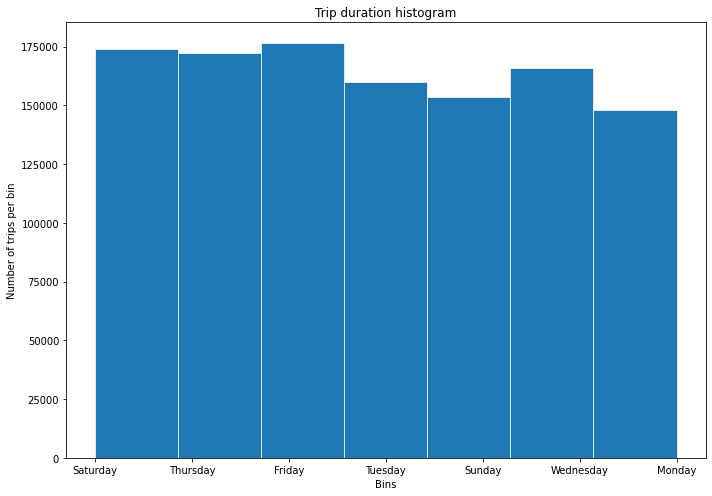

In [33]:
# Busiest pickup days
plot_histogram('pickup_day_name', 'Trip duration histogram',
               'Number of trips per bin', 7)

Όπως φαίνεται και στο παραπάνω ιστόγραμμα η πιο πολυσύχναστη pickup day είναι η Παρασκευή ακολουθούμενη απο το Σάββατο και την Πέμπτη.

***Ιστογραμμα για τις πιο πολυσύχναστες dropoff days***

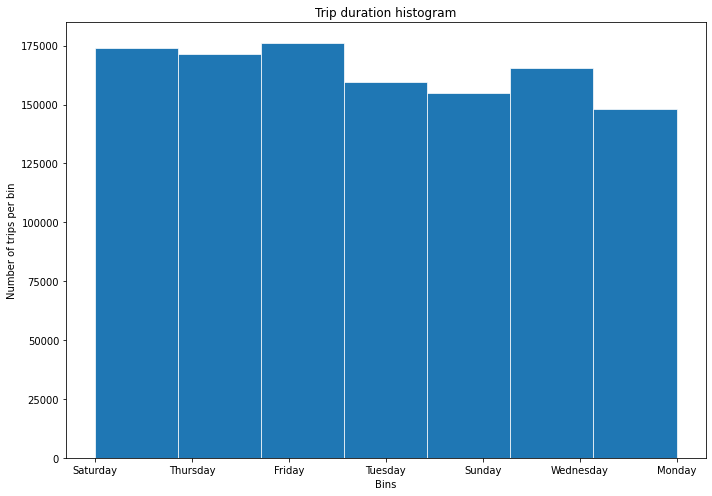

In [34]:
# Busiest dropoff days
plot_histogram('dropoff_day_name', 'Trip duration histogram',
               'Number of trips per bin', 7)

Αντίστοιχα όπως φαίνεται στο παραπάνω το ίδιο ακριβώς ισχύει και για τις πιο πολυσύχναστες dropoff days, δηλαδή πρώτα είναι η Παρασκευή και ακολουθεί το Σάββατο και η Πέμπτη.

***Ιστόγραμμα για Trips per day_period (pickup)***

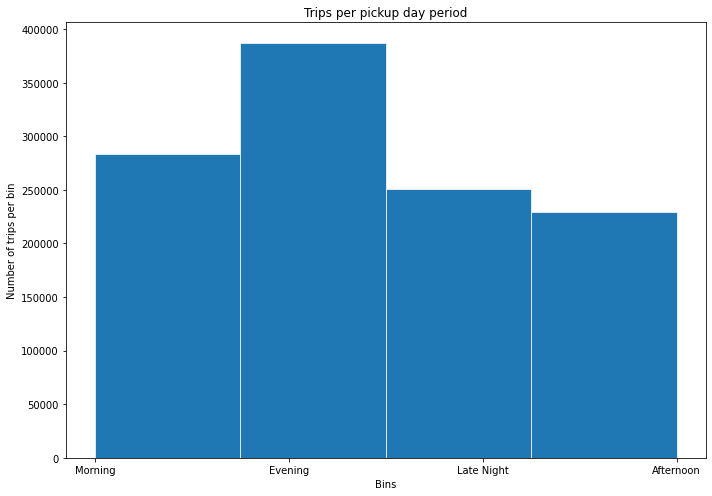

In [35]:
# Trips per pickup day period
plot_histogram('pickup_day_period', 'Trips per pickup day period',
               'Number of trips per bin', 4)

Όπως παρατηρούμε στο ιστόγραμμα τα περισσότερα trips per day_period γίνονται με διαφορά το απόγευμα (Evening).

***Ιστόγραμμα για Trips per day_period (dropoff)***

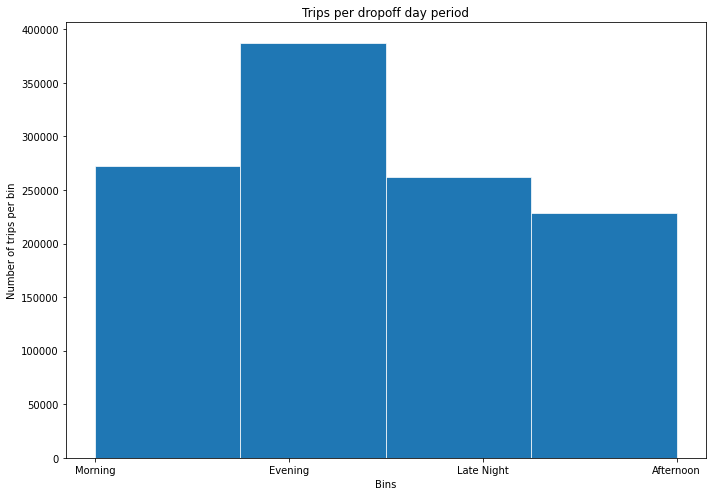

In [36]:
# Trips per dropoff day period
plot_histogram('dropoff_day_period', 'Trips per dropoff day period',
               'Number of trips per bin', 4)

Το ίδιο ισχύει επίσης και για τα dropoff trips per day_period.

***Ιστόγραμμα για Trips per month (pickup)***

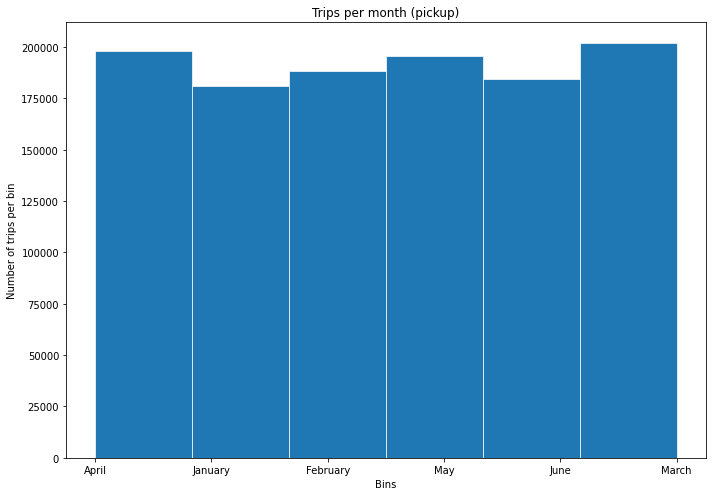

In [37]:
# Trips per month (pickup)
plot_histogram('pickup_month', 'Trips per month (pickup)',
               'Number of trips per bin', 6)

***Ιστόγραμμα για Trips per month (dropoff)***

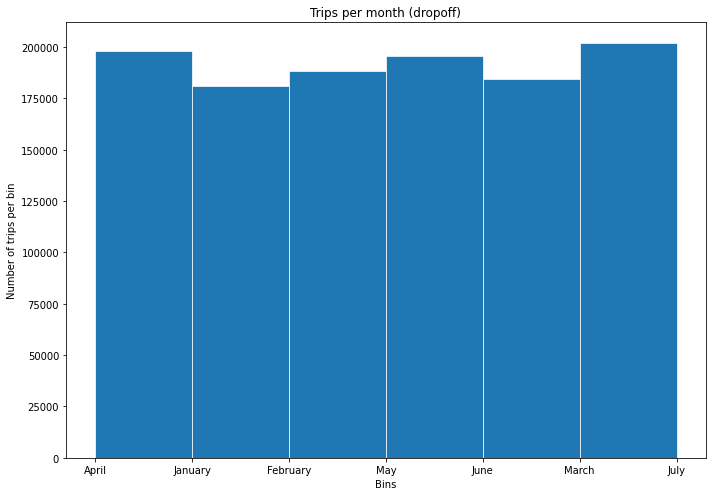

In [38]:
# Trips per month (dropoff)
plot_histogram('dropoff_month', 'Trips per month (dropoff)',
               'Number of trips per bin', 6)

### Create diagrams

In [39]:
def create_diagram(y_values, x_values, title, xlabel, ylabel):
  fig = plt.figure(figsize=(10, 5))

  plt.bar(y_values, x_values, color='maroon')

  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.show()

***Μέση διάρκεια ταξιδιού ανά pickup hour***

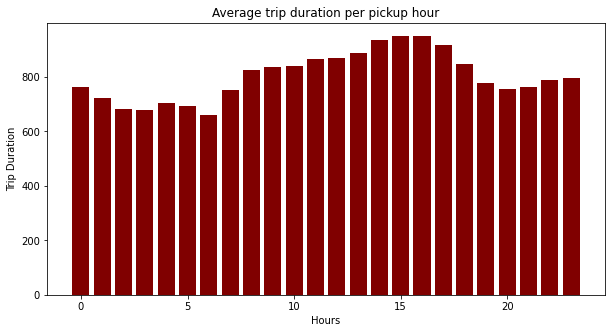

In [40]:
# Average trip duration per pickup hour
avg_trip_durations = df_train.groupby(['pickup_hour'])['trip_duration'].mean()

create_diagram(avg_trip_durations.keys().tolist(), avg_trip_durations.tolist(),\
              "Average trip duration per pickup hour",\
              "Hours", "Trip Duration")

***Μέση διάρκεια ταξιδιού ανά day_period***

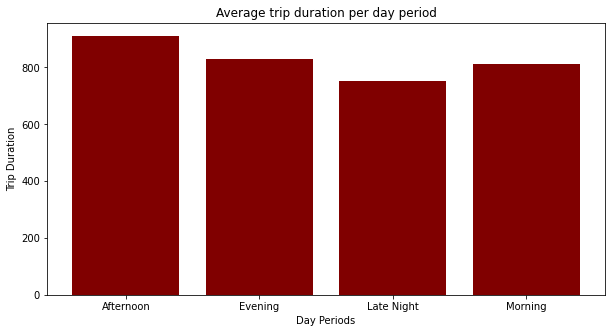

In [41]:
# Average trip duration per day_period
avg_trip_durations = df_train.groupby(['pickup_day_period'])['trip_duration'].mean()

create_diagram(avg_trip_durations.keys().tolist(), avg_trip_durations.tolist(),\
              "Average trip duration per day period",\
              "Day Periods", "Trip Duration")

***Μέση διάρκεια ταξιδιού ανά Day of Week***

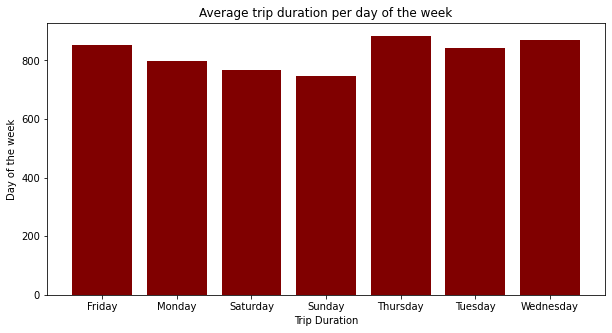

In [42]:
# Average trip duration per day of the week
avg_trip_durations = df_train.groupby(['pickup_day_name'])['trip_duration'].mean()

create_diagram(avg_trip_durations.keys().tolist(), avg_trip_durations.tolist(),\
              "Average trip duration per day of the week",\
              "Trip Duration", "Day of the week")

## 4.

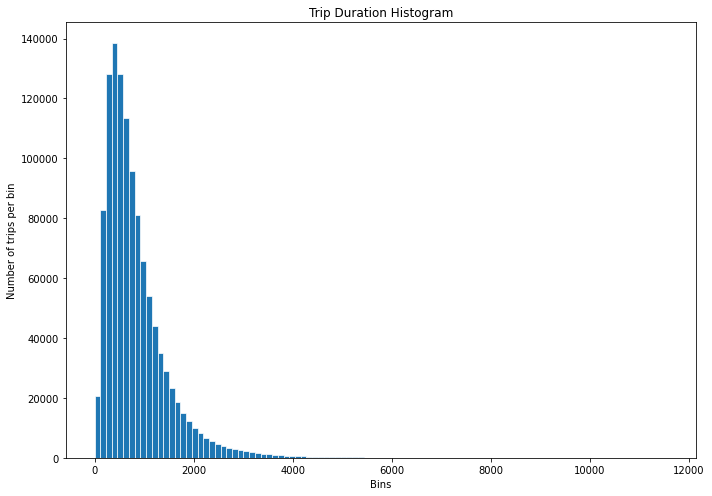

In [43]:
# Trip Duration Histogram (100 bins)
plot_histogram('trip_duration', 'Trip Duration Histogram',
               'Number of trips per bin', 100)

### a. Apply log transformation

In [44]:
# Apply log transformation in 'trip_duration' column and create a new column
df_train['log_trip_duration'] = np.log(df_train['trip_duration']) 

### b. Plot the log_trip_duration histogram

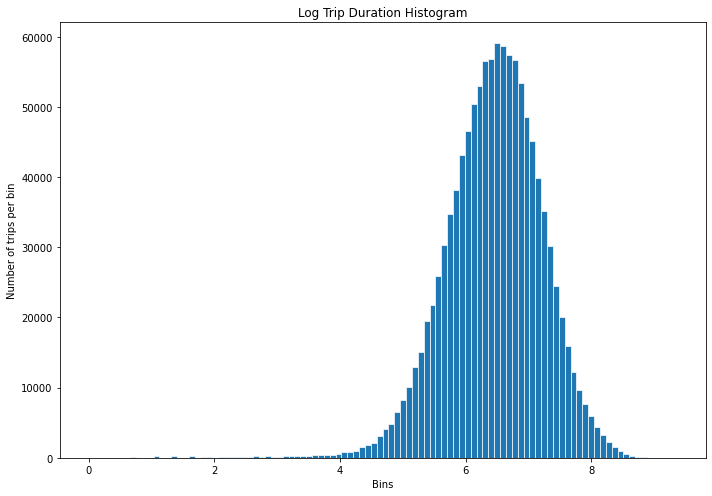

In [45]:
# Trip Duration Histogram (100 bins)
plot_histogram('log_trip_duration', 'Log Trip Duration Histogram',
               'Number of trips per bin', 100)

## **5.** Average trip duration per vendor

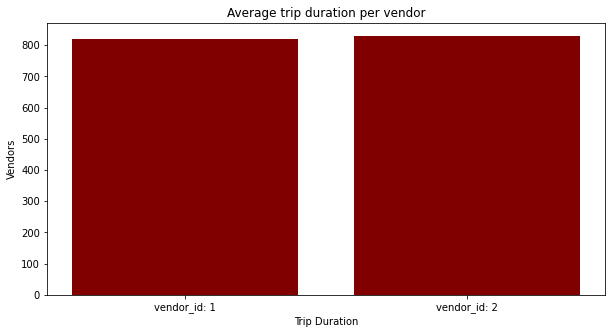

In [46]:
# Calculate the avg trip duration per vendor
avg_trip_durations = df_train.groupby(['vendor_id'])['trip_duration'].mean()

create_diagram(['vendor_id: 1', 'vendor_id: 2'], avg_trip_durations.tolist(),
               'Average trip duration per vendor','Trip Duration','Vendors')

Άρα παρατηρούμε πως ο πρώτος πάροχος (vendor 1) έχει μικρότερη μέση διάρκεια ταξιδιού απο τον δεύτερο πάροχο (vendor 2), αλλά η διαφορά είναι ελάχιστη και δεν θα έχει μεγάλο αντίκτυπο στην πρόβλεψη του χρόνου ταξιδιού, όπως θα δούμε παρακάτω.

## **6.** Trip Duration per number of passengers

Αρχικά θα αφαιρέσουμε τα δεδομένα όπου το passenger_count = 0 καθώς είναι προφανώς invalid. Δεν μπορεί να υπάρξει ταξίδι χωρίς κανέναν επιβάτη. Υπάρχουν 44 τέτοια rows στο df_train.

In [47]:
# Drop the rows where passenger_count is 0
df_train.drop(df_train[df_train['passenger_count'] == 0].index, inplace = True)

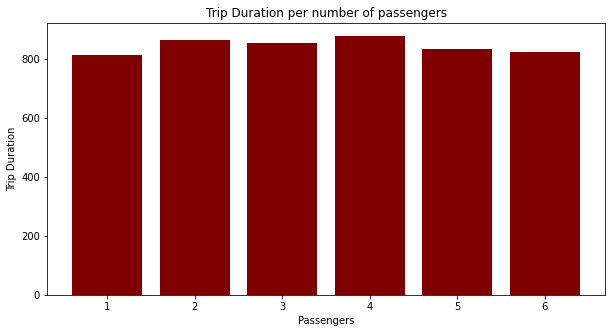

In [48]:
pass_counts = df_train.groupby(['passenger_count'])['trip_duration'].mean()

create_diagram(pass_counts.keys().tolist(), pass_counts.tolist(),
               'Trip Duration per number of passengers',
               'Passengers','Trip Duration')

Όπως φαίνεται και απο το παραπάνω διάγραμμα ο αριθμός των επιβατών δεν επηρεάζει σημαντικά τον χρόνο του ταξιδιού. Αυτό θα επιβεβαιωθεί και στην συνέχεια όπου θα χρησιμοποιήσουμε τον αριθμό των επιβατών για την πρόβλεψη του χρόνου ταξιδιού, χωρίς να έχει σημαντικό αποτέλεσμα.

## **7.** Manhattan Distance

In [49]:
from sklearn.metrics.pairwise import manhattan_distances

In [50]:
def find_manhattan_dist(dataframe):

  distances = []

  for index, row in dataframe.iterrows():
      long_x = row['pickup_longitude']
      lat_x = row['pickup_latitude']

      long_y = row['dropoff_longitude']
      lat_y = row['dropoff_latitude']

      point1 = [long_x, lat_x]
      point2 = [long_y, lat_y]

      dist = manhattan_distances([point1], [point2])
      distances.append(dist[0][0] * 1609.344)        # convert from miles to km

  return distances

In [51]:
# Add the new column to the train as well as the test dataframe
df_train['manhattan_dist'] = find_manhattan_dist(df_train)
df_test['manhattan_dist'] = find_manhattan_dist(df_test)

***Μέση απόσταση διαδρομής ανά ημέρα της εβδομάδας***

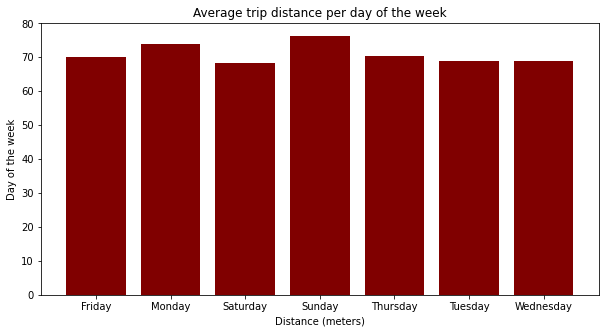

In [52]:
mean_dist = df_train.groupby(['pickup_day_name'])['manhattan_dist'].mean()

create_diagram(mean_dist.keys().tolist(), mean_dist.tolist(),\
              "Average trip distance per day of the week",\
              "Distance (meters)", "Day of the week")

Άρα παρατηρούμε πως τις Κυριακές η μέση απόσταση διαδρομής είναι η μεγαλύτερη και ακολουθεί η Δευτέρα.

***Απόσταση διαδρομής και χρόνος διαδρομής***


Text(0, 0.5, 'Trip Duration')

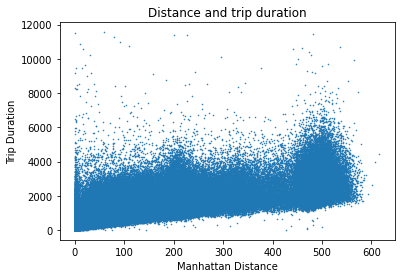

In [53]:
plt.scatter(df_train.manhattan_dist, df_train.trip_duration, s = 0.3)
plt.title("Distance and trip duration")
plt.xlabel("Manhattan Distance")
plt.ylabel("Trip Duration")

Άρα όπως φαίνεται από το παραπάνω scatter plot υπάρχει άμεση σύνδεση της απόστασης (manhattan distance) και του χρόνου διαδρομής (trip duration). Με άλλα λόγια, η αύξηση της απόστασης έχει ως αποτέλεσμα την αύξηση του χρόνου της διαδρομής.

## **8.** Average Speed

In [54]:
def find_avg_speed(column_name):

  mean_dist = df_train.groupby([column_name])['manhattan_dist'].mean()
  mean_time = df_train.groupby([column_name])['trip_duration'].mean()

  avg_speed = mean_dist / mean_time

  return avg_speed

***Μέση ταχύτητα και ώρα της ημέρας***

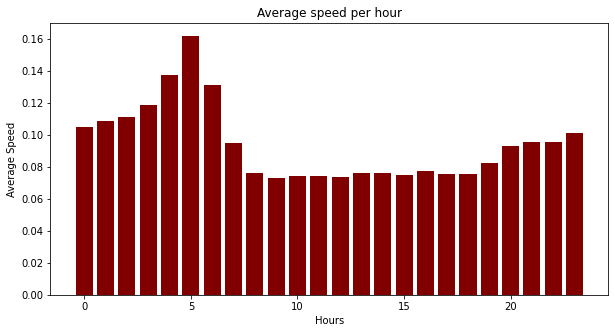

In [55]:
avg_speed = find_avg_speed('pickup_hour')

create_diagram(avg_speed.keys().tolist(), avg_speed.tolist(),\
              "Average speed per hour",\
              "Hours", "Average Speed")

Άρα όπως φαίνεται στο παραπάνω διάγραμμα στις ώρες 4:00 - 6:00 AM εντοπίζεται η μεγαλύτερη μέση ταχύτητα. Αυτό είναι αναμενόμενο καθώς εκείνες τις ώρες δεν συνηθίζεται να υπάρχει μποτιλιάρισμα και πολυκοσμία, με αποτέλεσμα το κάθε όχημα που κυκλοφορεί να μπορεί να μετακινηθεί με μεγαλύτερη ταχύτητα.

***Μέση ταχύτητα και ημέρα της εβδομάδας***

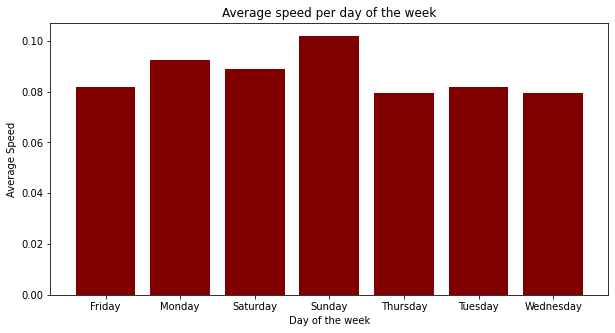

In [56]:
avg_speed = find_avg_speed('pickup_day_name')

create_diagram(avg_speed.keys().tolist(), avg_speed.tolist(),\
              "Average speed per day of the week",\
              "Day of the week", "Average Speed")

***Μέση ταχύτητα και μήνας του έτους***

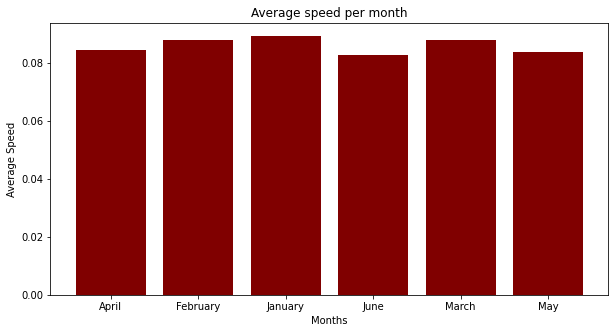

In [57]:
avg_speed = find_avg_speed('pickup_month')

create_diagram(avg_speed.keys().tolist(), avg_speed.tolist(),\
              "Average speed per month",\
              "Months", "Average Speed")

Αν και δεν παρατηρείται μεγάλη απόκλιση μεταξύ των μηνών όσον αφορά τη μέση ταχύτητα, ο μήνας που παρατηρείται η μεγαλύτερη μέση ταχύτητα είναι ο Ιανουάριος και ο μήνας που παρατηρείται η μικρότερη μέση ταχύτητα είναι ο Ιούνιος. 

## **9.** Create scatter plots

***Scater plot για τα pickup σημεία***

Text(0, 0.5, 'Latitude')

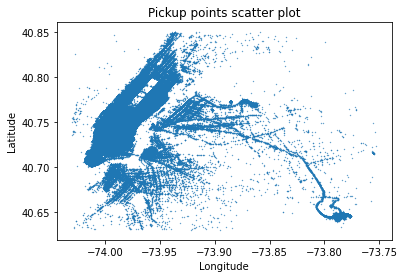

In [58]:
# Create the first scatter plot for the pickup points
plt.scatter(df_train.pickup_longitude, df_train.pickup_latitude, s = 0.1)
plt.title("Pickup points scatter plot")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

***Scater plot για τα dropoff σημεία***

Text(0, 0.5, 'Latitude')

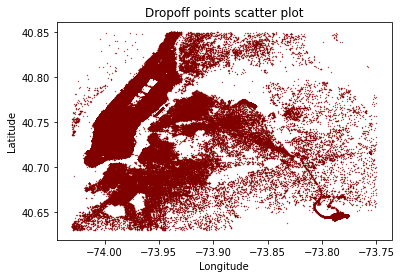

In [59]:
# Create the second scatter plot for the dropoff points
plt.scatter(df_train.dropoff_longitude, df_train.dropoff_latitude, s = 0.1, c = 'maroon')
plt.title("Dropoff points scatter plot")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Clustering

Μέχρι τώρα χρησιμοποιούσαμε όλο το dataset, αλλά απο εδώ και στο εξής, δηλαδή στο κομμάτι του Clustering, θα χρησιμοποιήσουμε **περίπου το 20%**.

In [60]:
# Keep 50% of the data set
LIMIT = 200000
df_train = df_train[:LIMIT]

## 1.

In [61]:
from sklearn.cluster import KMeans

In [62]:
df_array = df_train[["pickup_longitude","pickup_latitude"]].to_numpy()

In [63]:
# ---------- Elbow Method ----------

# Calculate the score for different K-mean values
sse = []
for k in range(1, 11):
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(df_array)
  sse.append(kmeans.inertia_)

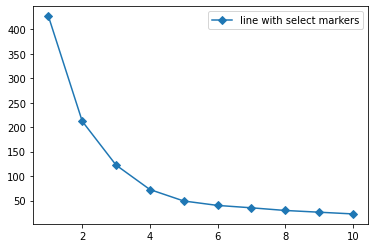

In [64]:
markers_on = [12, 17, 18, 19]
plt.plot(range(1, 11), sse, '-D', label='line with select markers')
plt.legend()
plt.show()

Άρα χρησιμοποιώντας την μέθοδο elbow και σύμφωνα με το παραπάνω διάγραμμα μπορούμε να συμπαιράνουμε πως ο βέλτιστος αριθμός κέντρων, είναι ο αριθμός 4. Επομένως θα εκπαιδεύσουμε τον K-means με αριθμό κέντρων (n_clusters) = 4.

Επιλέγοντας n_clusters = 4 έχουμε ένα λογικό trade-off μεταξύ πολυπλοκότητας και απόδοσης.

In [65]:
Kmean = KMeans(n_clusters=4)
Kmean.fit(df_array)

KMeans(n_clusters=4)

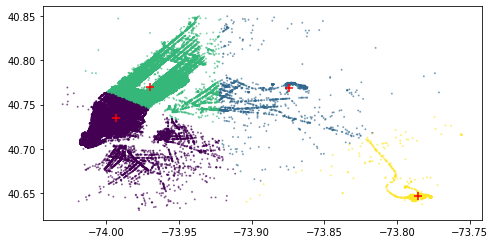

In [66]:
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True

fig = plt.figure()
ax = fig.add_subplot(111)

scatter = ax.scatter(df_train.pickup_longitude, df_train.pickup_latitude,
                     c=Kmean.labels_, s=1, alpha = 0.5)

for i, j in Kmean.cluster_centers_:
   ax.scatter(i, j, s=70, c='red', marker='+')

plt.show()

Στο παραπάνω διάγραμμα φαίνονται τα σημεία του df_train με χρώμα που αντιστοιχεί στο cluster που ανήκουν (χρησιμοποιώντας το 20% των data καθώς και 4 clusters).

Επίσης φαίνονται με κόκκινο χρώμα και τα κεντροειδή των τεσσάρων clusters.

## 2.

In [67]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.metrics import r2_score

In [68]:
number = preprocessing.LabelEncoder()

df_train['pickup_day_period'] = number.fit_transform(df_train.pickup_day_period)
df_test['pickup_day_period'] = number.fit_transform(df_test.pickup_day_period)

df_train['pickup_day_name'] = number.fit_transform(df_train.pickup_day_name)
df_test['pickup_day_name'] = number.fit_transform(df_test.pickup_day_name)

In [69]:
important_features = ['vendor_id', 'passenger_count' ,'pickup_longitude', 
                      'pickup_latitude', 'dropoff_latitude' ,'dropoff_longitude',
                      'pickup_day_period', 'pickup_day_name',
                      'pickup_hour', 'manhattan_dist']

# create regressor object
regressor = RandomForestRegressor()

# fit the regressor
regressor.fit(df_train[important_features], df_train['log_trip_duration']) 

RandomForestRegressor()

In [70]:
# test the output by changing values
Y_pred = regressor.predict(df_test[important_features])

In [71]:
# Apply log transformation in 'trip_duration' column on target_csv
df_target['log_trip_duration'] = np.log(df_target['trip_duration'])

r2_score(df_target['log_trip_duration'], Y_pred)

0.7080316119888292

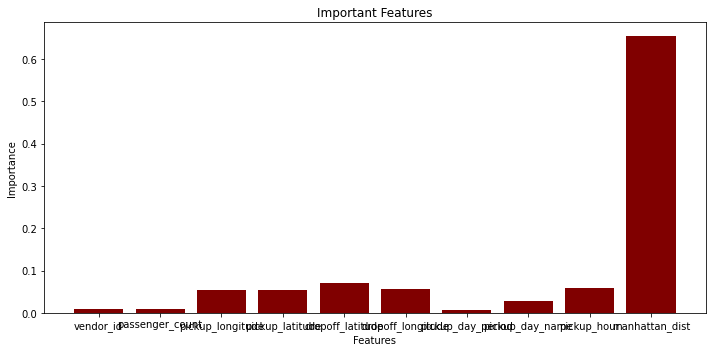

In [72]:
# Plot the important features graph
importances = regressor.feature_importances_

create_diagram(important_features,  importances.tolist(),
              "Important Features",
              "Features", "Importance")

Όπως φαίνεται και στο παραπάνω διάγραμμα το πιο σημαντικό χαρακτηριστικό είναι με διαφορά η manhattan_distance εφόσον η απόσταση της διαδρομής σχετίζεται άμεσα με τον χρόνο που θα χρειαστεί.

Στη συνέχεια ακολουθούν τα: pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude καθώς και τα pickup_day_name και pickup_hour.

In [73]:
important_features = ['pickup_longitude', 
                      'pickup_latitude', 'dropoff_latitude' ,'dropoff_longitude',
                      'pickup_day_name',
                      'pickup_hour', 'manhattan_dist']

## 3.

In [74]:
from sklearn.model_selection import GridSearchCV

In [75]:
param_grid = {'max_depth': [15, None], 
              'max_features': ['auto', 'log2'], 
              'n_estimators': [100, 150]}

rfr = RandomForestRegressor(random_state = 1)

g_search = GridSearchCV(estimator = rfr,
param_grid = param_grid, cv = 3, n_jobs = 1, verbose = 0)

In [76]:
g_search.fit(df_train[important_features], df_train['log_trip_duration'])

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=1), n_jobs=1,
             param_grid={'max_depth': [15, None],
                         'max_features': ['auto', 'log2'],
                         'n_estimators': [100, 150]})

In [77]:
g_search.best_params_

{'max_depth': None, 'max_features': 'log2', 'n_estimators': 150}

Έτσι συμπαιρένουμε πως οι βέλτιστες παραμέτροι είναι: max_depth = None, max_features = log2 και n_estimators = 150. 

## 4.

Στη συνέχεια εκπαιδεύουμε τον RandomForestRegressor με τις νέες παραμέτρους και υπολογίζουμε ξανά το νέο score.

In [78]:
# create regressor object
regressor = RandomForestRegressor(max_depth= None, max_features = 'log2', n_estimators= 150, random_state=1)

# fit the regressor
regressor.fit(df_train[important_features], df_train['log_trip_duration']) 

RandomForestRegressor(max_features='log2', n_estimators=150, random_state=1)

In [79]:
# test the output by changing values
Y_pred = regressor.predict(df_test[important_features])

In [80]:
score = r2_score(df_target['log_trip_duration'],Y_pred)

In [81]:
print(score)

0.7113417696356481


Άρα όπως φαίνεται παραπάνω το score αυξήθηκε από 0.70770 σε 0.71134 με την χρήση της GridSearchCV για την εύρεση των βέλτιστων παραμέτρων.

## 5.

Στο βήμα αυτό θα υπολογίσουμε την απόδοση χρησιμοποιώντας τις μετρικές ΜΑE (Mean Absolute Error) και MSE (Mean Squared Error).

In [82]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [83]:
mae = mean_absolute_error(df_target['log_trip_duration'], Y_pred)
mse = mean_squared_error(df_target['log_trip_duration'], Y_pred)

In [84]:
print('MAE is: ' , mae)
print('MSE is: ', mse)
print('Score is:', score)

MAE is:  0.2740423504489232
MSE is:  0.18523666588117108
Score is: 0.7113417696356481


# Bonus

## 1.

In [85]:
import folium

In [86]:
df_list = df_train[['pickup_longitude','pickup_latitude']].values.tolist()

map = folium.Map(location=df_list[0])
for cord in df_list:
  folium.Marker(location=[cord[0], cord[1]]).add_to(map)

In [87]:
map.save('map.html')

## 2

### a.

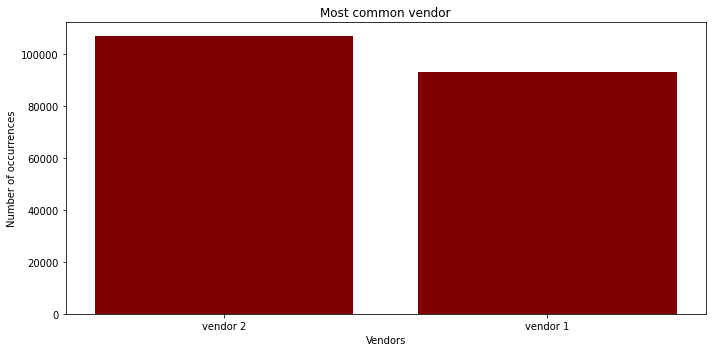

In [88]:
vendor_counts = df_train['vendor_id'].value_counts()

create_diagram(['vendor 2', 'vendor 1'], vendor_counts.tolist(),\
              "Most common vendor",\
              "Vendors", "Number of occurrences")

In [89]:
vendor_counts

2    106898
1     93102
Name: vendor_id, dtype: int64

Άρα ο πιο συχνός vendor ανάμεσα στους δύο είναι ο vendor 2 με αριθμό εμφανίσεων 106898 στα 93102 data samples (εφόσον έχουμε ορίσει LIMIT = 200000)

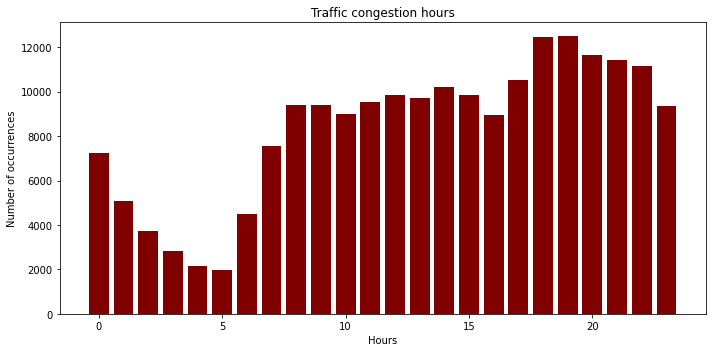

In [90]:
traffic_congestion = df_train['pickup_hour'].value_counts()

create_diagram(traffic_congestion.keys().tolist(), traffic_congestion.tolist(),\
              "Traffic congestion hours",\
              "Hours", "Number of occurrences")

Όπως φαίνεται και απο το διάγραμμα οι ώρες που παρατηρείται traffic congestion είναι κυρίως 18:00 - 20:00. 

### b.

Αρχικά θα προσθέσουμε ένα feature που θα δείχνει αν η διαδρομή έγινε ΣΚ ή όχι και θα δούμε αν υπάρχει κάποια βελτίωση στο μοντέλο.

In [91]:
def add_is_weekend(df):

  day_names = df['pickup_day_name']

  conditions = [
      ((day_names == 'Saturday') | (day_names == 'Sunday')),    # is weekend
      ((day_names != 'Saturday') & (day_names != 'Sunday'))     # is not weekend
      ]

  values = ['Yes', 'No']

  df['is_weekend'] = np.select(conditions, values)

  return df

In [92]:
df_train = add_is_weekend(df_train)
df_test = add_is_weekend(df_test)

In [93]:
df_train['is_weekend'] = number.fit_transform(df_train.is_weekend)
df_test['is_weekend'] = number.fit_transform(df_test.is_weekend)

In [94]:
important_features = ['pickup_longitude', 
                      'pickup_latitude', 'dropoff_latitude' ,'dropoff_longitude',
                      'is_weekend',
                      'pickup_hour', 'manhattan_dist']

In [95]:
# create regressor object
regressor = RandomForestRegressor(max_depth= None, max_features = 'log2', n_estimators= 150, random_state=1)

# fit the regressor
regressor.fit(df_train[important_features], df_train['log_trip_duration'])

# test the output by changing values
Y_pred = regressor.predict(df_test[important_features])

score = r2_score(df_target['log_trip_duration'],Y_pred)